In [14]:
# =============================================================================
# IMPORTS
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.feature_selection import SelectKBest, mutual_info_regression
import warnings
warnings.filterwarnings('ignore')

# Configuración visual
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Reproducibilidad
np.random.seed(42)

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✅ Librerías cargadas correctamente")
print(f"   Pandas: {pd.__version__}")
print(f"   NumPy: {np.__version__}")

✅ Librerías cargadas correctamente
   Pandas: 2.3.3
   NumPy: 1.26.4


Cargando dataset base...
Dataset cargado exitosamente
   Dimensiones: (4496, 15)
   Rango: 2008-01-31 00:00:00 ? 2025-12-30 00:00:00
   Total d?as: 4496
División completada correctamente

TRAIN SET:
   Período: 2008-01-31 00:00:00 - 2018-10-17 00:00:00
   Días: 2697 (60.0%)

VALIDATION SET:
   Período: 2018-10-18 00:00:00 - 2022-05-19 00:00:00
   Días: 899 (20.0%)

TEST SET:
   Período: 2022-05-20 00:00:00 - 2025-12-30 00:00:00
   Días: 900 (20.0%)


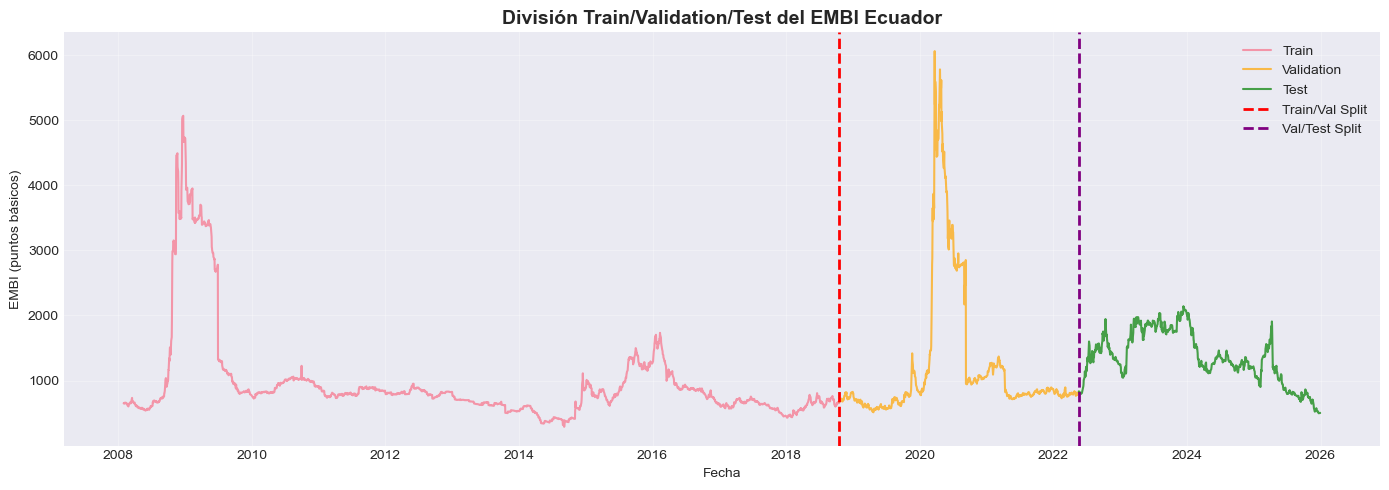

In [15]:
# =============================================================================
# 1.1 CARGA DE DATOS
# =============================================================================
print("Cargando dataset base...")

try:
    df = pd.read_pickle('dataset_tesis_final.pkl')
    print("Dataset cargado exitosamente")
    print(f"   Dimensiones: {df.shape}")
    print(f"   Rango: {df.index.min()} ? {df.index.max()}")
    print(f"   Total d?as: {len(df)}")
except FileNotFoundError:
    print("ERROR: No se encuentra 'dataset_tesis_final.pkl'")
    raise

# Asegurar índice temporal ordenado
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index, errors='coerce')

df = df.sort_index()

# =============================================================================
# 1.2 DIVISIÓN TEMPORAL (TRAIN / VAL / TEST) - ANTES DE FEATURE ENGINEERING
# =============================================================================
TRAIN_RATIO = 0.60
VAL_RATIO = 0.20
TEST_RATIO = 0.20

assert abs(TRAIN_RATIO + VAL_RATIO + TEST_RATIO - 1.0) < 1e-6, "ERROR: Las proporciones no suman 1.0"

n_total = len(df)
train_end = int(n_total * TRAIN_RATIO)
val_end = int(n_total * (TRAIN_RATIO + VAL_RATIO))

train = df.iloc[:train_end].copy()
val = df.iloc[train_end:val_end].copy()
test = df.iloc[val_end:].copy()

# Validar la división
assert train.index.max() < val.index.min(), "ERROR: Hay solapamiento temporal entre train y val"
assert val.index.max() < test.index.min(), "ERROR: Hay solapamiento temporal entre val y test"
assert len(train) + len(val) + len(test) == len(df), "ERROR: Se perdieron filas en la divisi?n"

# Fechas de corte
train_end_date = train.index.max()
val_start_date = val.index.min()
val_end_date = val.index.max()
test_start_date = test.index.min()

print("División completada correctamente")
print("")
print("TRAIN SET:")
print(f"   Período: {train.index.min()} - {train.index.max()}")
print(f"   Días: {len(train)} ({len(train)/len(df)*100:.1f}%)")
print("")
print("VALIDATION SET:")
print(f"   Período: {val.index.min()} - {val.index.max()}")
print(f"   Días: {len(val)} ({len(val)/len(df)*100:.1f}%)")
print("")
print("TEST SET:")
print(f"   Período: {test.index.min()} - {test.index.max()}")
print(f"   Días: {len(test)} ({len(test)/len(df)*100:.1f}%)")

# Visualizaci?n de la divisi?n
plt.figure(figsize=(14, 5))
plt.plot(train.index, train['target_embi'], label='Train', alpha=0.7)
plt.plot(val.index, val['target_embi'], label='Validation', alpha=0.7, color='orange')
plt.plot(test.index, test['target_embi'], label='Test', alpha=0.7, color='green')
plt.axvline(x=val_start_date, color='red', linestyle='--', linewidth=2, label='Train/Val Split')
plt.axvline(x=test_start_date, color='purple', linestyle='--', linewidth=2, label='Val/Test Split')
plt.title('División Train/Validation/Test del EMBI Ecuador', fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('EMBI (puntos básicos)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## **Definición del Target**
---
Queremos predecir el **EMBI de mañana (t+1)** usando información de **hoy (t)**.


In [16]:
# =============================================================================
# 2. CREACIÓN DEL TARGET FUTURO (t+1)
# =============================================================================
print("Creando variable target (EMBI t+1)...")

# Crear target futuro en cada conjunto POR SEPARADO
train['target_future'] = train['target_embi'].shift(-1)
val['target_future'] = val['target_embi'].shift(-1)
test['target_future'] = test['target_embi'].shift(-1)

# La última fila de cada conjunto tendrá NaN en target_future
print("Target creado")
print(f"   Train: {train['target_future'].notna().sum()} valores válidos, {train['target_future'].isna().sum()} NaN (Última fila)")
print(f"   Val:   {val['target_future'].notna().sum()} valores válidos, {val['target_future'].isna().sum()} NaN (Última fila)")
print(f"   Test:  {test['target_future'].notna().sum()} valores válidos, {test['target_future'].isna().sum()} NaN (Última fila)")



Creando variable target (EMBI t+1)...
Target creado
   Train: 2696 valores válidos, 1 NaN (Última fila)
   Val:   898 valores válidos, 1 NaN (Última fila)
   Test:  899 valores válidos, 1 NaN (Última fila)


## Feature Engineering
---
Se busca generar la parte "AR" - lags y "MA" - medias móviles. Simulando la dinámica de los modelos ARIMA y de series de tiempo tradicionales, para capturar efectos tardíos de ciertos cambios en las variables.

In [17]:
# =============================================================================
# 3.1 FUNCIÓN DE FEATURE ENGINEERING
# =============================================================================

# Parámetros globales de lags y ventanas móviles
LAGS = (1, 7, 30)
ROLLING_WINDOWS = (7, 30)


def create_time_features(df, lags=LAGS, rolling_windows=ROLLING_WINDOWS, verbose=True):
    '''
    Genera features de lags y rolling means para todas las columnas numéricas.

    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame con índice temporal que contiene 'target_future'
    lags : tuple
        Lags a generar (en días)
    rolling_windows : tuple
        Ventanas para medias móviles (en días)
    verbose : bool
        Si True, imprime informaci?n del proceso

    Retorna:
    --------
    df_eng : pd.DataFrame
        DataFrame con todas las features generadas
    '''
    if verbose:
        print(f"   Procesando {df.shape[0]} filas...")

    # Identificar columnas numéricas (excluir target_future)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'target_future' in numeric_cols:
        numeric_cols.remove('target_future')

    if verbose:
        print(f"   Variables base: {len(numeric_cols)}")

    # Crear copia para no modificar el original
    df_eng = df.copy()

    # Diccionario para almacenar nuevas columnas (m?s eficiente que frame.insert)
    new_features = {}

    # Generar features para cada columna
    for col in numeric_cols:
        # LAGS
        for lag in lags:
            new_features[f'{col}_lag{lag}'] = df_eng[col].shift(lag)

        # ROLLING MEANS (con shift para evitar leakage)
        for window in rolling_windows:
            new_features[f'{col}_roll_mean{window}'] = (
                df_eng[col]
                .rolling(window=window, min_periods=window)
                .mean()
                .shift(1)
            )

    # Convertir diccionario a DataFrame y concatenar
    new_features_df = pd.DataFrame(new_features, index=df_eng.index)
    df_eng = pd.concat([df_eng, new_features_df], axis=1)

    if verbose:
        print(f"   Features generados: {len(new_features)} nuevas columnas")
        print(f"   Dimensiones finales: {df_eng.shape}")

    return df_eng

print("    Función create_time_features() definida")
print(f"   Lags: {LAGS} | Rolling windows: {ROLLING_WINDOWS}")


    Función create_time_features() definida
   Lags: (1, 7, 30) | Rolling windows: (7, 30)


In [18]:
# =============================================================================
# 3.2 APLICAR FEATURE ENGINEERING
# =============================================================================
print("Generando features para TRAIN...")
train_eng = create_time_features(train, lags=LAGS, rolling_windows=ROLLING_WINDOWS, verbose=True)

print("")
print("Generando features para VALIDATION...")
val_eng = create_time_features(val, lags=LAGS, rolling_windows=ROLLING_WINDOWS, verbose=True)

print("")
print("Generando features para TEST...")
test_eng = create_time_features(test, lags=LAGS, rolling_windows=ROLLING_WINDOWS, verbose=True)

# Verificar que todos los conjuntos tienen las mismas columnas
assert train_eng.columns.equals(val_eng.columns), "?? ERROR: Train y Val tienen columnas diferentes"
assert train_eng.columns.equals(test_eng.columns), " ERROR: Train y Test tienen columnas diferentes"
print("")
print("? Verificación: Train, Val y Test tienen las mismas columnas")

# Mostrar ejemplo de features generados
print("")
print(" Ejemplo de features generados (primeras 5 columnas nuevas):")
feature_cols = [col for col in train_eng.columns if '_lag' in col or '_roll' in col]
print(train_eng[feature_cols[:5]].head())


Generando features para TRAIN...
   Procesando 2697 filas...
   Variables base: 15
   Features generados: 75 nuevas columnas
   Dimensiones finales: (2697, 91)

Generando features para VALIDATION...
   Procesando 899 filas...
   Variables base: 15
   Features generados: 75 nuevas columnas
   Dimensiones finales: (899, 91)

Generando features para TEST...
   Procesando 900 filas...
   Variables base: 15
   Features generados: 75 nuevas columnas
   Dimensiones finales: (900, 91)

? Verificación: Train, Val y Test tienen las mismas columnas

 Ejemplo de features generados (primeras 5 columnas nuevas):
            target_embi_lag1  target_embi_lag7  target_embi_lag30  \
date                                                                
2008-01-31               NaN               NaN                NaN   
2008-02-01             649.0               NaN                NaN   
2008-02-04             655.0               NaN                NaN   
2008-02-05             649.0               NaN   

## Limpieza de Valores Nulos

Después de crear lags y rolling means, tendremos NaNs en:
- **Primeras 30 filas**: Por los lags de 30 días
- **Última fila**: Por el target_future (shift(-1))

Estos NaNs son esperados y debemos eliminarlos antes de entrenar modelos.

In [19]:
# =============================================================================
# 4. LIMPIEZA DE VALORES NULOS
# =============================================================================
print("Eliminando filas con valores nulos...")

# Guardar dimensiones antes de limpiar
train_before = len(train_eng)
val_before = len(val_eng)
test_before = len(test_eng)

# Eliminar NaNs
train_clean = train_eng.dropna()
val_clean = val_eng.dropna()
test_clean = test_eng.dropna()

# Calcular p?rdidas
train_lost = train_before - len(train_clean)
val_lost = val_before - len(val_clean)
test_lost = test_before - len(test_clean)

print("")
print("TRAIN:")
print(f"   Antes: {train_before} filas")
print(f"   Después: {len(train_clean)} filas")
print(f"   Perdidas: {train_lost} filas ({train_lost/train_before*100:.2f}%)")

print("")
print("VALIDATION:")
print(f"   Antes: {val_before} filas")
print(f"   Después: {len(val_clean)} filas")
print(f"   Perdidas: {val_lost} filas ({val_lost/val_before*100:.2f}%)")

print("")
print("TEST:")
print(f"   Antes: {test_before} filas")
print(f"   Después: {len(test_clean)} filas")
print(f"   Perdidas: {test_lost} filas ({test_lost/test_before*100:.2f}%)")

# Verificación de seguridad
assert len(train_clean) > 0, "?? ERROR: Train quedó vacío después de limpiar"
assert len(val_clean) > 0, "?? ERROR: Validation quedó vacío después de limpiar"
assert len(test_clean) > 0, "?? ERROR: Test quedó vacío después de limpiar"
assert train_clean.isna().sum().sum() == 0, "?? ERROR: Aún hay NaNs en train"
assert val_clean.isna().sum().sum() == 0, "?? ERROR: Aún hay NaNs en validation"
assert test_clean.isna().sum().sum() == 0, "?? ERROR: Aún hay NaNs en test"

print("")
print("? Limpieza completada. No quedan valores nulos.")


Eliminando filas con valores nulos...

TRAIN:
   Antes: 2697 filas
   Después: 2666 filas
   Perdidas: 31 filas (1.15%)

VALIDATION:
   Antes: 899 filas
   Después: 868 filas
   Perdidas: 31 filas (3.45%)

TEST:
   Antes: 900 filas
   Después: 869 filas
   Perdidas: 31 filas (3.44%)

? Limpieza completada. No quedan valores nulos.


In [20]:
# =============================================================================
# 5. FEATURE SELECTION CON MUTUAL INFORMATION
# =============================================================================
N_FEATURES = 60  # Número de features a seleccionar

print(f"? Seleccionando Top {N_FEATURES} features con Mutual Information...")

# Separar X (features) e y (target) SOLO DEL TRAIN
X_train = train_clean.drop(columns=['target_future'])
y_train = train_clean['target_future']

print(f"   Features disponibles: {X_train.shape[1]}")
print(f"   Filas de entrenamiento: {len(X_train)}")

# Configurar y entrenar el selector
selector = SelectKBest(score_func=mutual_info_regression, k=N_FEATURES)

print("   Calculando Mutual Information (esto puede tardar ~30 segundos)...")
selector.fit(X_train, y_train)

# Obtener nombres de las columnas seleccionadas
selected_mask = selector.get_support()
selected_features = X_train.columns[selected_mask].tolist()

# Verificaci?n
assert len(selected_features) == N_FEATURES, f"ERROR: Se seleccionaron {len(selected_features)} en lugar de {N_FEATURES}"

print("")
print(f"? Selección completada: {len(selected_features)} features")

# Aplicar selección a todos los conjuntos
X_train_selected = X_train[selected_features]
X_val_selected = val_clean.drop(columns=['target_future'])[selected_features]
X_test_selected = test_clean.drop(columns=['target_future'])[selected_features]

# Verificar que todos tienen las mismas columnas
assert X_val_selected.columns.equals(X_train_selected.columns), "ERROR: Columnas diferentes en train/val"
assert X_test_selected.columns.equals(X_train_selected.columns), "ERROR: Columnas diferentes en train/test"

print(f"   Train shape: {X_train_selected.shape}")
print(f"   Val shape:   {X_val_selected.shape}")
print(f"   Test shape:  {X_test_selected.shape}")


? Seleccionando Top 60 features con Mutual Information...
   Features disponibles: 90
   Filas de entrenamiento: 2666
   Calculando Mutual Information (esto puede tardar ~30 segundos)...

? Selección completada: 60 features
   Train shape: (2666, 60)
   Val shape:   (868, 60)
   Test shape:  (869, 60)


In [21]:
# =============================================================================
# 6. RECONSTRUCCIÓN DE DATAFRAMES FINALES
# =============================================================================
print("? Reconstruyendo datasets finales...")

# Concatenar features + target
train_final = pd.concat([X_train_selected, y_train], axis=1)
val_final = pd.concat([X_val_selected, val_clean['target_future']], axis=1)
test_final = pd.concat([X_test_selected, test_clean['target_future']], axis=1)

# Verificaciones finales
assert train_final.shape[1] == N_FEATURES + 1, f"ERROR: Train debería tener {N_FEATURES + 1} columnas"
assert val_final.shape[1] == N_FEATURES + 1, f"ERROR: Val debería tener {N_FEATURES + 1} columnas"
assert test_final.shape[1] == N_FEATURES + 1, f"ERROR: Test debería tener {N_FEATURES + 1} columnas"
assert train_final.columns.equals(val_final.columns), "ERROR: Train y Val tienen columnas diferentes"
assert train_final.columns.equals(test_final.columns), "ERROR: Train y Test tienen columnas diferentes"
assert train_final.isna().sum().sum() == 0, "ERROR: Hay NaNs en train_final"
assert val_final.isna().sum().sum() == 0, "ERROR: Hay NaNs en val_final"
assert test_final.isna().sum().sum() == 0, "ERROR: Hay NaNs en test_final"

print("Datasets finales creados correctamente")
print("")
print("DIMENSIONES FINALES:")
print(f"   Train: {train_final.shape} ({train_final.shape[1]-1} features + 1 target)")
print(f"   Val:   {val_final.shape} ({val_final.shape[1]-1} features + 1 target)")
print(f"   Test:  {test_final.shape} ({test_final.shape[1]-1} features + 1 target)")

# Mostrar primeras filas
print("")
print("Primeras filas de train_final:")
print(train_final.head())


? Reconstruyendo datasets finales...
Datasets finales creados correctamente

DIMENSIONES FINALES:
   Train: (2666, 61) (60 features + 1 target)
   Val:   (868, 61) (60 features + 1 target)
   Test:  (869, 61) (60 features + 1 target)

Primeras filas de train_final:
            target_embi     oil_wti  index_dxy    etf_emb         gold  \
date                                                                     
2008-03-14          694  110.209999  71.660004  42.535557   998.200012   
2008-03-17          733  105.680000  71.459999  42.447086  1001.400024   
2008-03-18          678  109.419998  71.570000  42.657810  1003.200012   
2008-03-19          687  104.480003  72.139999  42.708344   944.700012   
2008-03-20          687  101.839996  72.750000  42.699905   919.599976   

              etf_hyg  macro_reservas_int  macro_balanza_comercial  \
date                                                                 
2008-03-14  31.316771          3989.42123              -454.906325   
2008-

In [22]:
# =============================================================================
# IMPORTANCIA DE FEATURES
# =============================================================================
print("⏳ Generando análisis visual...")

# Obtener scores de las features seleccionadas
scores = selector.scores_[selected_mask]

# Crear DataFrame para análisis
features_scores = pd.DataFrame({
    'Feature': selected_features,
    'Score': scores
}).sort_values(by='Score', ascending=False)

# Categorizar features
def categorize_feature(feature_name):
    if 'nlp' in feature_name.lower():
        return 'NLP'
    elif 'macro' in feature_name.lower():
        return 'Macroeconómico'
    elif any(x in feature_name for x in ['oil', 'gold', 'etf', 'treasury', 'vix', 'dxy']):
        return 'Financiero'
    else:
        return 'Otro'

features_scores['Category'] = features_scores['Feature'].apply(categorize_feature)

# Contar features por categoría
category_counts = features_scores['Category'].value_counts()

print("\n DISTRIBUCIÓN DE FEATURES POR CATEGORÍA:")
for cat, count in category_counts.items():
    pct = count / N_FEATURES * 100
    print(f"   {cat:20s}: {count:2d} features ({pct:5.1f}%)")

# Top 10 features
print("\n🏆 TOP 10 FEATURES MÁS IMPORTANTES:")
for idx, row in features_scores.head(10).iterrows():
    print(f"   {row['Feature']:40s} | Score: {row['Score']:.4f} | {row['Category']}")

⏳ Generando análisis visual...

 DISTRIBUCIÓN DE FEATURES POR CATEGORÍA:
   Financiero          : 29 features ( 48.3%)
   Macroeconómico      : 23 features ( 38.3%)
   Otro                :  6 features ( 10.0%)
   NLP                 :  2 features (  3.3%)

🏆 TOP 10 FEATURES MÁS IMPORTANTES:
   target_embi                              | Score: 3.1704 | Otro
   target_embi_lag1                         | Score: 2.6968 | Otro
   macro_reservas_int_lag7                  | Score: 2.4334 | Macroeconómico
   macro_reservas_int_lag30                 | Score: 2.4333 | Macroeconómico
   macro_reservas_int_lag1                  | Score: 2.3799 | Macroeconómico
   macro_reservas_int                       | Score: 2.3769 | Macroeconómico
   target_embi_roll_mean7                   | Score: 2.3344 | Otro
   etf_hyg_roll_mean30                      | Score: 2.3293 | Financiero
   etf_emb_roll_mean30                      | Score: 2.1571 | Financiero
   target_embi_lag7                         | Score:

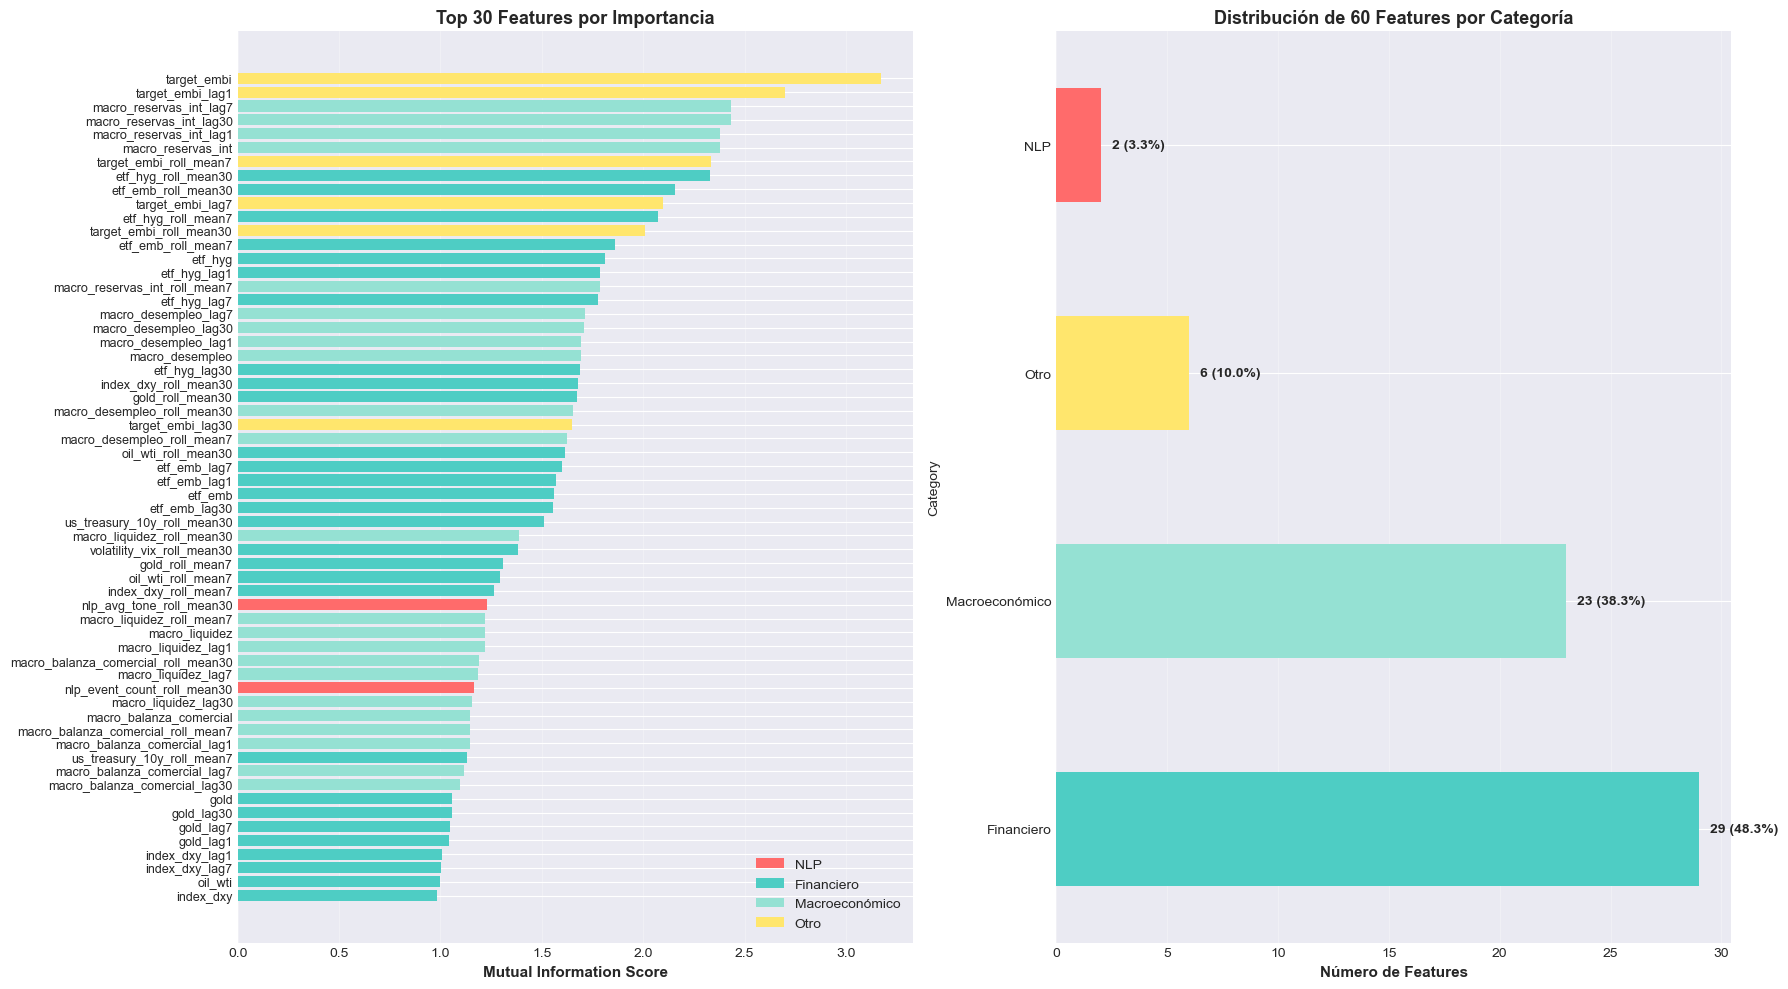


✅ Visualizaciones generadas


In [23]:
# =============================================================================
# 7.2 VISUALIZACIONES
# =============================================================================

# Gráfico 1: Top 30 Features con colores por categoría
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Panel izquierdo: Top 30 features
top_30 = features_scores.head(60)
colors = {'NLP': '#FF6B6B', 'Financiero': '#4ECDC4', 'Macroeconómico': '#95E1D3', 'Otro': '#FFE66D'}
bar_colors = [colors[cat] for cat in top_30['Category']]

axes[0].barh(range(len(top_30)), top_30['Score'], color=bar_colors)
axes[0].set_yticks(range(len(top_30)))
axes[0].set_yticklabels(top_30['Feature'], fontsize=9)
axes[0].invert_yaxis()
axes[0].set_xlabel('Mutual Information Score', fontsize=11, fontweight='bold')
axes[0].set_title('Top 30 Features por Importancia', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Leyenda personalizada
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=cat) for cat, color in colors.items()]
axes[0].legend(handles=legend_elements, loc='lower right', fontsize=10)

# Panel derecho: Distribución por categoría
category_counts.plot(kind='barh', ax=axes[1], color=[colors[cat] for cat in category_counts.index])
axes[1].set_xlabel('Número de Features', fontsize=11, fontweight='bold')
axes[1].set_title(f'Distribución de {N_FEATURES} Features por Categoría', fontsize=13, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# Añadir valores en las barras
for i, (cat, count) in enumerate(category_counts.items()):
    axes[1].text(count + 0.5, i, f'{count} ({count/N_FEATURES*100:.1f}%)', 
                 va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ Visualizaciones generadas")


 ANÁLISIS DETALLADO DE VARIABLES NLP (2 seleccionadas):
   Rank #39 | nlp_avg_tone_roll_mean30                      | Score: 1.227548
   Rank #45 | nlp_event_count_roll_mean30                   | Score: 1.166474

 ESTADÍSTICAS:
   Score promedio NLP: 1.197011
   Score promedio general: 1.581894
   Ratio: 0.76x


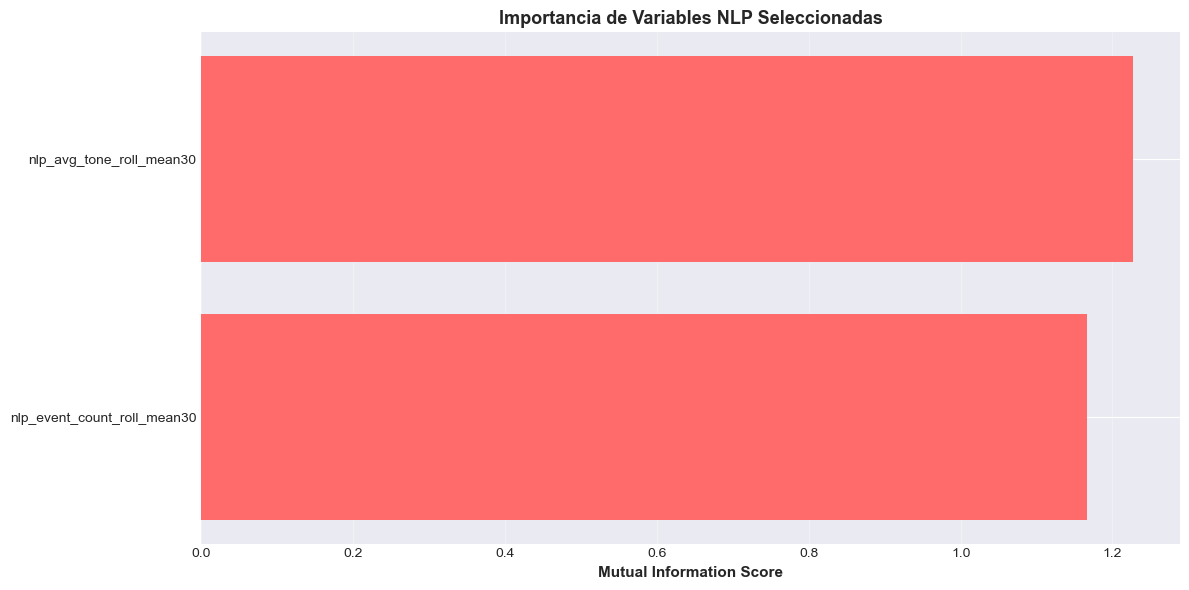

In [24]:
# =============================================================================
# 7.3 ANÁLISIS ESPECÍFICO DE VARIABLES NLP
# =============================================================================
nlp_features = features_scores[features_scores['Category'] == 'NLP'].copy()

if len(nlp_features) > 0:
    print(f"\n ANÁLISIS DETALLADO DE VARIABLES NLP ({len(nlp_features)} seleccionadas):")
    print("=" * 80)
    
    for idx, row in nlp_features.iterrows():
        rank = features_scores.index.get_loc(idx) + 1
        print(f"   Rank #{rank:2d} | {row['Feature']:45s} | Score: {row['Score']:.6f}")
    
    # Estadísticas de variables NLP
    nlp_avg_score = nlp_features['Score'].mean()
    overall_avg_score = features_scores['Score'].mean()
    
    print(f"\n ESTADÍSTICAS:")
    print(f"   Score promedio NLP: {nlp_avg_score:.6f}")
    print(f"   Score promedio general: {overall_avg_score:.6f}")
    print(f"   Ratio: {nlp_avg_score/overall_avg_score:.2f}x")
    
    # ¿Cuántas están en el top 20?
    nlp_in_top20 = len(features_scores.head(20)[features_scores.head(20)['Category'] == 'NLP'])
    
    # Visualización de NLP features
    if len(nlp_features) > 0:
        plt.figure(figsize=(12, max(6, len(nlp_features) * 0.3)))
        plt.barh(range(len(nlp_features)), nlp_features['Score'], color='#FF6B6B')
        plt.yticks(range(len(nlp_features)), nlp_features['Feature'], fontsize=10)
        plt.xlabel('Mutual Information Score', fontsize=11, fontweight='bold')
        plt.title('Importancia de Variables NLP Seleccionadas', fontsize=13, fontweight='bold')
        plt.grid(axis='x', alpha=0.3)
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
else:
    print("\n ADVERTENCIA: No se seleccionaron variables NLP")

In [25]:
# =============================================================================
# 8. GUARDADO DE DATASETS Y METADATA
# =============================================================================

# Archivo 1: Train
train_final.to_pickle('train_feature_engineered.pkl')
print("Guardado: train_feature_engineered.pkl")

# Archivo 2: Validation
val_final.to_pickle('val_feature_engineered.pkl')
print("Guardado: val_feature_engineered.pkl")

# Archivo 3: Test
test_final.to_pickle('test_feature_engineered.pkl')
print("Guardado: test_feature_engineered.pkl")

# Archivo 4: Metadata (para documentaci?n y Notebook 04)
metadata = {
    'split_strategy': 'chronological_ratio',
    'train_ratio': TRAIN_RATIO,
    'val_ratio': VAL_RATIO,
    'test_ratio': TEST_RATIO,
    'split_dates': {
        'train_end': str(train_final.index.max()),
        'val_start': str(val_final.index.min()),
        'val_end': str(val_final.index.max()),
        'test_start': str(test_final.index.min())
    },
    'n_features': N_FEATURES,
    'selected_features': selected_features,
    'feature_scores': dict(zip(selected_features, scores)),
    'feature_categories': dict(zip(features_scores['Feature'], features_scores['Category'])),
    'train_period': (str(train_final.index.min()), str(train_final.index.max())),
    'val_period': (str(val_final.index.min()), str(val_final.index.max())),
    'test_period': (str(test_final.index.min()), str(test_final.index.max())),
    'train_size': len(train_final),
    'val_size': len(val_final),
    'test_size': len(test_final),
    'nlp_features_count': len(nlp_features) if len(nlp_features) > 0 else 0
}

# Compatibilidad hacia atr?s (si otro notebook esperaba 'split_date')
metadata['split_date'] = metadata['split_dates']['val_start']

with open('feature_selector_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)
print("Guardado: feature_selector_metadata.pkl")

print("")
print("="*80)
print("TODOS LOS ARCHIVOS GUARDADOS EXITOSAMENTE")
print("="*80)


Guardado: train_feature_engineered.pkl
Guardado: val_feature_engineered.pkl
Guardado: test_feature_engineered.pkl
Guardado: feature_selector_metadata.pkl

TODOS LOS ARCHIVOS GUARDADOS EXITOSAMENTE


## 9. Reporte Final y Validaciones

Resumen completo del proceso y verificación de que todo está correcto para el modelado.

In [26]:
# =============================================================================
# 9. REPORTE FINAL
# =============================================================================

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'target_embi' in numeric_cols:
    numeric_cols.remove('target_embi')

features_per_var = len(LAGS) + len(ROLLING_WINDOWS)
max_lookback = max(max(LAGS), max(ROLLING_WINDOWS))

print("")
print("="*80)
print("?? REPORTE FINAL - FEATURE ENGINEERING & SELECTION")
print("="*80)

print("")
print(" DIVISI?N TEMPORAL (por ratios):")
print(f"   Train: {train_final.index.min().date()} ? {train_final.index.max().date()} ({len(train_final)} d?as)")
print(f"   Val:   {val_final.index.min().date()} ? {val_final.index.max().date()} ({len(val_final)} d?as)")
print(f"   Test:  {test_final.index.min().date()} ? {test_final.index.max().date()} ({len(test_final)} d?as)")

print("")
print(" FEATURE ENGINEERING:")
print(f"   Variables originales: {len(numeric_cols)}")
print(f"   Lags usados: {LAGS}")
print(f"   Rolling windows usados: {ROLLING_WINDOWS}")
print(f"   Features generados por variable: {features_per_var}")
print(f"   Total features generados: {len(numeric_cols) * features_per_var}")
print(f"   Lookback m?ximo requerido: {max_lookback} d?as")
print(f"   Features despu?s de selecci?n: {N_FEATURES}")

print("")
print(" DISTRIBUCI?N DE FEATURES:")
for cat, count in category_counts.items():
    pct = count / N_FEATURES * 100
    bar = '?' * int(pct / 2)
    print(f"   {cat:20s}: {count:2d} ({pct:5.1f}%) {bar}")

print("")
print(" VARIABLES NLP:")
if len(nlp_features) > 0:
    print(f"   Total seleccionadas: {len(nlp_features)}")
    print(f"   En top 20: {nlp_in_top20}")
    print(f"   Score promedio: {nlp_avg_score:.6f}")
    print(f"   Mejor ranking: #{features_scores[features_scores['Category']=='NLP'].index[0] + 1}")
else:
    print("   NINGUNA variable NLP fue seleccionada")
    print("   Esto requiere investigaci?n adicional en el preprocesamiento de GDELT")

print("")
print("ARCHIVOS GENERADOS:")
print(f"   train_feature_engineered.pkl ({train_final.shape})")
print(f"   val_feature_engineered.pkl ({val_final.shape})")
print(f"   test_feature_engineered.pkl ({test_final.shape})")
print("   feature_selector_metadata.pkl")

print("")
print("? VALIDACIONES:")
checks = [
    ("Train, Val y Test no se solapan temporalmente", train_final.index.max() < val_final.index.min() < test_final.index.min()),
    ("Todos los datasets tienen las mismas columnas", train_final.columns.equals(val_final.columns) and train_final.columns.equals(test_final.columns)),
    ("No hay valores nulos", train_final.isna().sum().sum() == 0 and val_final.isna().sum().sum() == 0 and test_final.isna().sum().sum() == 0),
    (f"Número correcto de features ({N_FEATURES} + 1 target)", train_final.shape[1] == N_FEATURES + 1 and val_final.shape[1] == N_FEATURES + 1 and test_final.shape[1] == N_FEATURES + 1),
    ("Índice temporal preservado", isinstance(train_final.index, pd.DatetimeIndex))
]

for check_name, check_result in checks:
    status = "?" if check_result else "?"
    print(f"   [{status}] {check_name}")

print("")
print("="*80)
print("FEATURE ENGINEERING COMPLETADO EXITOSAMENTE")
print("Próximo paso: Notebook 04 - Modelado de Machine Learning")
print("="*80)



?? REPORTE FINAL - FEATURE ENGINEERING & SELECTION

 DIVISI?N TEMPORAL (por ratios):
   Train: 2008-03-14 ? 2018-10-16 (2666 d?as)
   Val:   2018-11-30 ? 2022-05-18 (868 d?as)
   Test:  2022-07-06 ? 2025-12-29 (869 d?as)

 FEATURE ENGINEERING:
   Variables originales: 14
   Lags usados: (1, 7, 30)
   Rolling windows usados: (7, 30)
   Features generados por variable: 5
   Total features generados: 70
   Lookback m?ximo requerido: 30 d?as
   Features despu?s de selecci?n: 60

 DISTRIBUCI?N DE FEATURES:
   Financiero          : 29 ( 48.3%) ????????????????????????
   Macroeconómico      : 23 ( 38.3%) ???????????????????
   Otro                :  6 ( 10.0%) ?????
   NLP                 :  2 (  3.3%) ?

 VARIABLES NLP:
   Total seleccionadas: 2
   En top 20: 0
   Score promedio: 1.197011
   Mejor ranking: #40

ARCHIVOS GENERADOS:
   train_feature_engineered.pkl ((2666, 61))
   val_feature_engineered.pkl ((868, 61))
   test_feature_engineered.pkl ((869, 61))
   feature_selector_metadata.pk

### Al realizar Feature selection se puede observar que ha sido imposible que se incluyan variables de NLP de no ser porque se están tomando 60 variables. Esto puede indicar 2 puntos:

- NLP **no** tiene capacidad predictiva sobre EMBI.
- La variable creada desde bigquery en google cloud **puede mejorar**.